In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Exploratory Data Analysis (EDA)**

In [ ]:
import os
import zipfile

# Unzipping the dataset
zip_path = "/content/gdrive/MyDrive/Data Preprocessing Datasets/Real Life Violence Situations Dataset.zip"
extract_path = "/content/gdrive/MyDrive/Data Preprocessing Datasets/Real Life Violence Situations Dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Checking the contents of the inner "Real Life Violence Situations Dataset" folder
inner_folder = os.path.join(extract_path, 'Real Life Violence Situations Dataset')
dataset_contents = os.listdir(inner_folder)

In [ ]:
# Checking the number of video files in each folder

non_violence_folder = os.path.join(inner_folder, 'Non Violence')
violence_folder = os.path.join(inner_folder, 'Violence')

In [ ]:
import random

# Selecting a random video from each category
random_non_violence_video = random.choice(os.listdir(non_violence_folder))
random_violence_video = random.choice(os.listdir(violence_folder))

# Getting the sizes of the selected videos
non_violence_video_size = os.path.getsize(os.path.join(non_violence_folder, random_non_violence_video))
violence_video_size = os.path.getsize(os.path.join(violence_folder, random_violence_video))

In [ ]:
import cv2
import matplotlib.pyplot as plt

def extract_frames(video_path, num_frames=3):
    """Extracts specified number of frames from a video."""
    frames = []
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_indices = sorted(random.sample(range(total_frames), num_frames))

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    cap.release()
    return frames

# Extracting frames from the selected videos
non_violence_frames = extract_frames(os.path.join(non_violence_folder, random_non_violence_video))
violence_frames = extract_frames(os.path.join(violence_folder, random_violence_video))

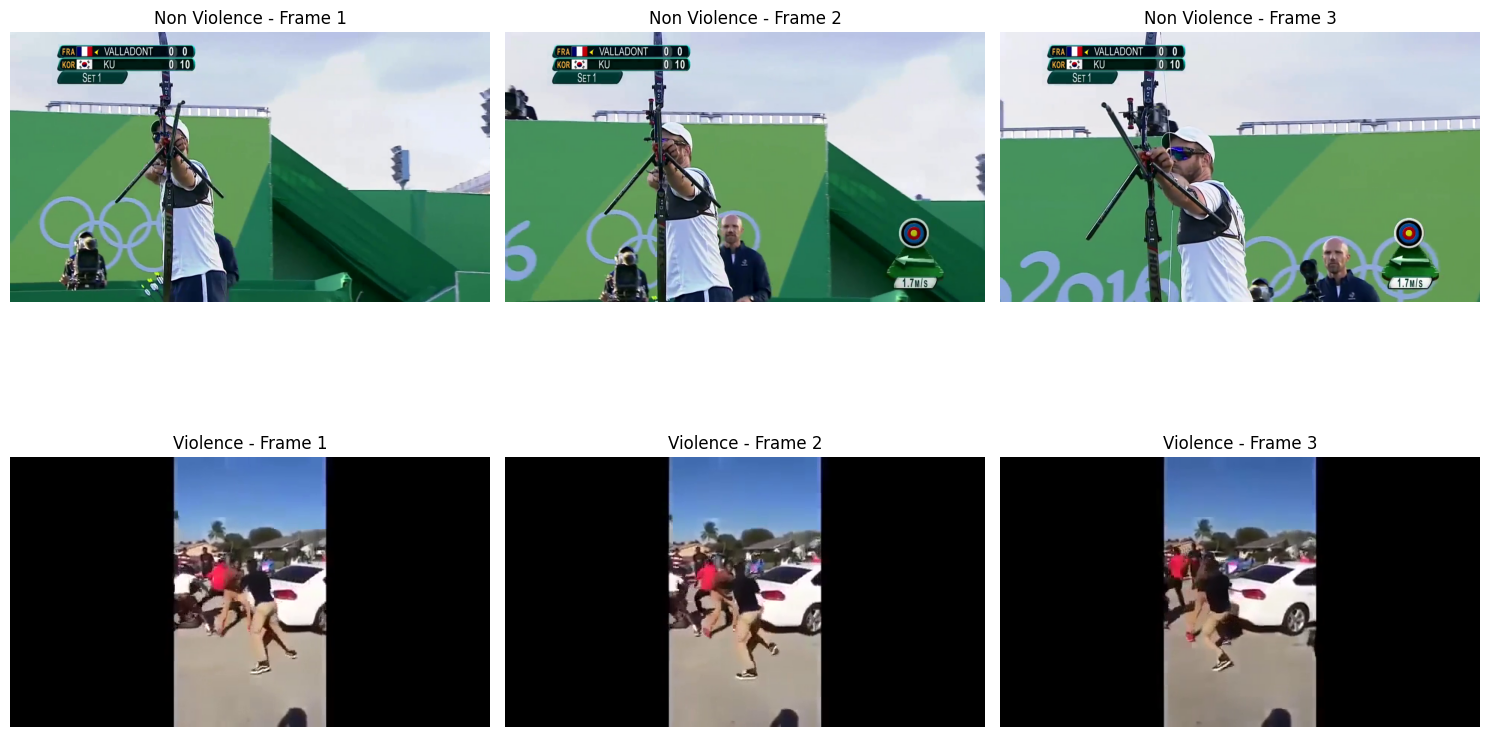

In [ ]:
# Plotting the extracted frames
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for ax, frame, title in zip(axes[0], non_violence_frames, ['Frame 1', 'Frame 2', 'Frame 3']):
    ax.imshow(frame)
    ax.set_title(f"Non Violence - {title}")
    ax.axis('off')

for ax, frame, title in zip(axes[1], violence_frames, ['Frame 1', 'Frame 2', 'Frame 3']):
    ax.imshow(frame)
    ax.set_title(f"Violence - {title}")
    ax.axis('off')

plt.tight_layout()
plt.show()

**Data Preprocessing**

In [ ]:
!pip install imageio

In [ ]:
import imageio
import os

# Paths to the dataset folders
non_violence_folder = "/content/gdrive/MyDrive/Data Preprocessing Datasets/Real Life Violence Situations Dataset/Real Life Violence Situations Dataset/Non Violence"
violence_folder = "/content/gdrive/MyDrive/Data Preprocessing Datasets/Real Life Violence Situations Dataset/Real Life Violence Situations Dataset/Violence"

def convert_video_to_images(video_path, output_folder):
    """Converts a video to a sequence of images."""
    # Ensure output directory exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    reader = imageio.get_reader(video_path)
    for i, frame in enumerate(reader):
        imageio.imwrite(os.path.join(output_folder, f"frame_{i:04d}.jpg"), frame)

# Convert Non Violence videos
for video_file in os.listdir(non_violence_folder):
    if not video_file.endswith('.mp4'):
        continue
    video_path = os.path.join(non_violence_folder, video_file)
    output_folder = os.path.join(non_violence_folder, video_file.split('.')[0])  # Creating a folder named after the video
    convert_video_to_images(video_path, output_folder)

# Convert Violence videos
for video_file in os.listdir(violence_folder):
    if not video_file.endswith('.mp4'):
        continue
    video_path = os.path.join(violence_folder, video_file)
    output_folder = os.path.join(violence_folder, video_file.split('.')[0])  # Creating a folder named after the video
    convert_video_to_images(video_path, output_folder)

print("Conversion completed!")

Conversion completed!


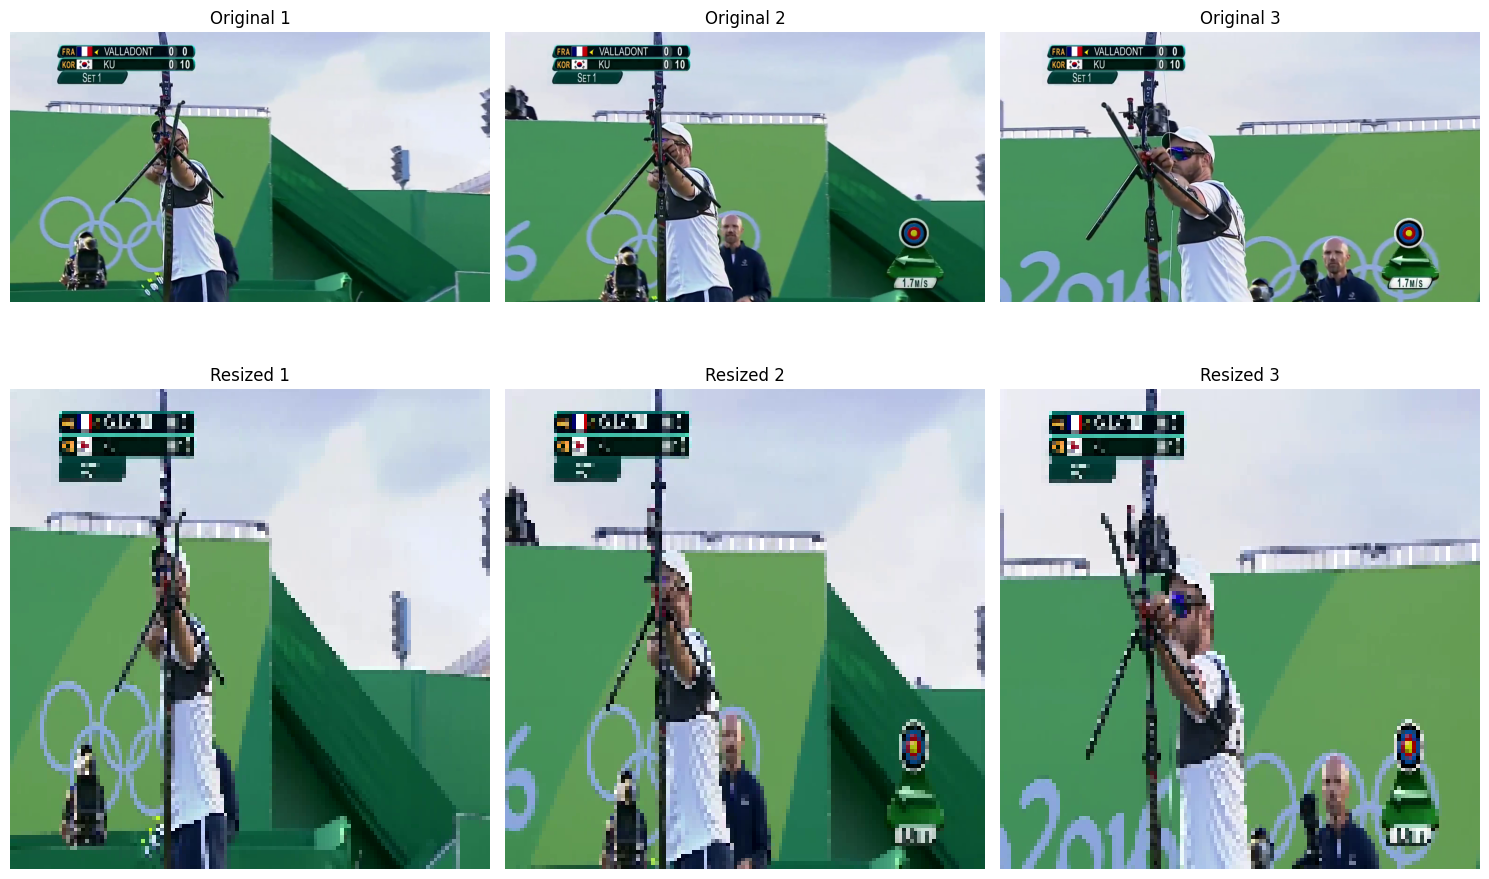

In [ ]:
def resize_frames(frames, target_size=(128, 128)):
    """Resizes a list of frames to the target size."""
    return [cv2.resize(frame, target_size) for frame in frames]

def normalize_frames(frames):
    """Normalizes pixel values of frames to range [0, 1]."""
    return [frame / 255.0 for frame in frames]

# Sample frames from our earlier extraction attempt (for demonstration)
sample_frames = non_violence_frames + violence_frames

# Resizing and normalizing the sample frames
resized_frames = resize_frames(sample_frames)
normalized_frames = normalize_frames(resized_frames)

# Displaying original vs. resized frames for comparison
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for ax, frame, title in zip(axes[0], sample_frames, ['Original 1', 'Original 2', 'Original 3']):
    ax.imshow(frame)
    ax.set_title(title)
    ax.axis('off')

for ax, frame, title in zip(axes[1], resized_frames, ['Resized 1', 'Resized 2', 'Resized 3']):
    ax.imshow(frame)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.4/257.4 MB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.44.0.1-py2.py3-none-any.whl size=257484150 sha256=0188a16ede2a5e94e687e9e0d8714cf95b517f9884c251801c48722a2574a423
  Stored in directory: /root/.cache/pip/wheels/d9/9b/ca/7345b72d17e1e17da37239d70631c3214ec9e541b0c9e700e2
Successfully built h2o


**Model Building using AutoML**

In [ ]:
import cv2
import os
import pandas as pd

In [ ]:
def process_images_from_directory(directory, label):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg'):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert image to grayscale
            flattened_img = img.flatten()  # Flatten the image
            data.append([label] + list(flattened_img))
    return data

In [ ]:
# Paths to your directories containing frames
non_violence_dir = "/content/gdrive/MyDrive/Data Preprocessing Datasets/Real Life Violence Situations Dataset/Real Life Violence Situations Dataset/Non Violence/NV_1000"
violence_dir = "/content/gdrive/MyDrive/Data Preprocessing Datasets/Real Life Violence Situations Dataset/Real Life Violence Situations Dataset/Violence/V_105"

data_non_violence = process_images_from_directory(non_violence_dir, 0)
data_violence = process_images_from_directory(violence_dir, 1)

# Combine data and create a DataFrame
all_data = data_non_violence + data_violence
df = pd.DataFrame(all_data, columns=['target'] + [f'pixel_{i}' for i in range(len(all_data[0])-1)])

# Save DataFrame as CSV
csv_path = "/content/gdrive/MyDrive/Data Preprocessing Datasets/Real Life Violence Situations Dataset/Real Life Violence Situations Dataset/processed_data.csv"
df.to_csv(csv_path, index=False)

In [ ]:
import h2o
from h2o.automl import H2OAutoML

# Initialize H2O cluster
h2o.init()

# Load your data: You'd convert your image data into a tabular format where each row is an image
# and columns are pixel values (flattened image). The target column would be 0 (non-violence) or 1 (violence).
data = h2o.import_file("/content/gdrive/MyDrive/Data Preprocessing Datasets/Real Life Violence Situations Dataset/Real Life Violence Situations Dataset/processed_data.csv")

# Split data into train and validation sets
train, valid = data.split_frame(ratios=[0.8], seed=1)

# Set the target and predictor variables
y = "target"
x = data.columns
x.remove(y)

# Run AutoML
aml = H2OAutoML(max_runtime_secs=3600, seed=1)
aml.train(x=x, y=y, training_frame=train, validation_frame=valid)

# View the leaderboard
lb = aml.leaderboard
print(lb)

# Use the best model for predictions
preds = aml.leader.predict(valid)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,3 mins 03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.1
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_unknownUser_zrel78
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.584 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
